In [1]:
import numpy as np
from scipy.optimize import minimize, brute
import scipy
from scipy.linalg import solve_continuous_lyapunov
from scipy.stats import multivariate_normal, norm 
from matplotlib import pyplot as plt
from scipy.io import loadmat
import os
np.set_printoptions(precision=4, suppress=True)
from itertools import groupby
from inference import * 
from utils import * 

In [2]:
def convert_params(params): 
    J = np.array([[-params[0], params[2]], [-params[3], -params[1]]])
    B = np.diagflat(params[4:6])**2 
    c = params[3]/params[0] 
    B[1, 1] += c*c*B[0, 0] 
    B[1, 0] = c*B[0, 0]
    B[0, 1] = B[1, 0] 
    return J, B 

In [3]:
class simple_model(): 
    
    def __init__(self, params, convert_params):
        self.J, B = convert_params(params)
        self.rv =  multivariate_normal([0, 0], B)
        self.rvm =  multivariate_normal([0, 0], np.diagflat(np.array(params[-2:])**2))
        
    def evolve(self, T, dt, n_frames, n_repeats):
        results = [] 
        for n in range(n_repeats): 
            y = np.zeros((2))
            res = np.zeros((n_frames, 2))
            for i in range(n_frames):
                for j in range(int(T/n_frames/dt)):
                    self._update(y, dt)
                res[i] = np.copy(y)+self.rvm.rvs()
            results.append(res.T) 
        return results 


    def _update(self, y, dt):
        det = self.J @ y * dt  
        sto = np.sqrt(dt)*self.rv.rvs()
        y += det + sto 
        
        
class measurement_inference(inference):
    
    def _minuslogP(self, params, trajs, dt):
        '''
        traj: 2 x T 
        '''
        J, B = self.convert_params(params)
        M = np.diagflat(params[-2:]**2)
        K = self._K(J, B, M)
        S = K @ np.linalg.inv(M) 
        self._set_up(J, dt)
        A = self.evo @ K @ self.evo.T 
        cov = self._cov(J, B) + A + M  
        invcov = np.linalg.inv(cov)
        sign, norm = np.linalg.slogdet(invcov)
        
        minuslogp = 0 
        for traj in trajs: 
            T = traj.shape[-1]-1
            xm = self.evo @ S @ traj[:, :-1]
            diff = (traj[:, 1:] - xm)
            minuslogp += np.einsum('ji,jk,ki', diff, invcov, diff).real/2 
            minuslogp -= T*norm/2
        return minuslogp
        
    def _K(self, J, B, M): 
        c = solve_continuous_lyapunov(J, -B) 
        return np.linalg.inv(np.linalg.inv(c)+np.linalg.inv(M)) 

### First, we make some simulations with known parameters and infer them with both inference methods

In [4]:
# params in order of [epsilon, gamma-mu*c, mu, c]
n_frames = 5000
dt = 3.3e-2 
T = n_frames*dt
n_repeats = 8

params = [0.1, 2, 0.2, 1, 0.04, 0.8, 0.01, 0.07]
J, B = convert_params(params)
print('J = ', J )
print('B = ', B )
print(np.linalg.eigvals(J))

m = simple_model(params, convert_params)
results = m.evolve(T, 5e-3, n_frames, n_repeats)

J =  [[-0.1  0.2]
 [-1.  -2. ]]
B =  [[0.0016 0.016 ]
 [0.016  0.8   ]]
[-0.2118 -1.8882]


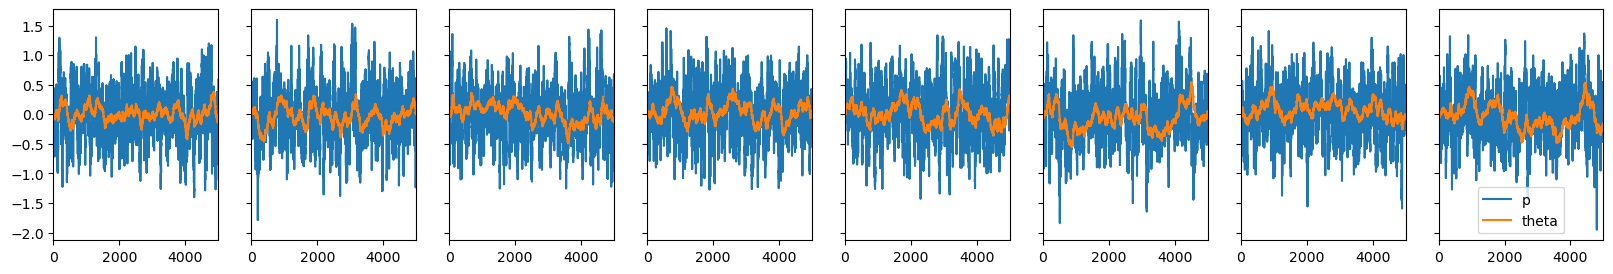

In [5]:
show(results)

In [6]:
## Inference without measurements 
inf = inference(convert_params)
guess = [0.1, 1, 1, 1, 1, 1]
bounds = [[1e-10, None]]*6 
MAP, cost = inf.inf(guess, results, dt, bounds=bounds)
print(MAP, cost)
print(np.array(params[:-2]), inf._minuslogP(np.array(params[:-2]), results, dt))

std_err, hess = inf.std_error(MAP, results, dt, delta=1e-3)
print('standard err: ', std_err)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


[0.2034 2.6889 0.1894 0.359  0.0874 1.0129] -195255.13874051155
[0.1  2.   0.2  1.   0.04 0.8 ] -132724.12469186948
standard err:  [0.015  0.0672 0.0058 0.0288 0.0003 0.0038]


In [7]:
## Inference with measurements
inf = measurement_inference(convert_params)
guess = [0.1, 1, 1, 1, 1, 1, 0.1, 0.1] 
bounds = [[1e-10, None]]*8 
bounds[-2] = [0.005, 0.02]
bounds[-1] = [0.05, 0.1] 
MAP, cost = inf.inf(guess, results, dt, bounds=bounds)
print(MAP, cost)
print(np.array(params), inf._minuslogP(np.array(params), results, dt))

[0.0895 2.0553 0.1848 0.9446 0.0356 0.8118 0.0102 0.0616] -195257.6890766246
[0.1  2.   0.2  1.   0.04 0.8  0.01 0.07] -195204.09837801877


In [8]:
delta = 1e-4*MAP 
delta[-1] = 1e-3
std_err, hess = inf.std_error(MAP, results, dt, delta)
print(std_err)

[   nan    nan 0.0056    nan    nan    nan    nan    nan]


/Users/yuli/Documents/Code/ActivePoly/inference.py:70: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diagonal(np.linalg.inv(hess))), hess


In [9]:
params = [0.1, 2, 0.2, 1, 0.04, 0.8, 0.01, 0.1]
n_repeats = 3

MAP1 = [] 
MAP2 = [] 

msigmas = [0.1, 0.07, 0.06, 0.03, 0.02, 0.01, 0.006, 0.003]
for msigma in msigmas: 
    params[-1] = msigma 
    m = simple_model(params, convert_params)
    results = m.evolve(T, 5e-3, n_frames, n_repeats)

    inf = inference(convert_params)
    guess = [1, 1, 1, 1, 1, 1]
    bounds = [[1e-10, None]]*6 
    MAP, cost = inf.inf(guess, results, dt, bounds=bounds)
    MAP1.append(MAP) 

    inf = measurement_inference(convert_params)
    guess = [*MAP, 0.1, 0.1] 
    bounds = [[1e-10, None]]*8 
    bounds[-2] = [0.005, 0.02]
    bounds[-1] = msigma*np.array([0.5, 2]) 
    MAP, cost = inf.inf(guess, results, dt, bounds=bounds)
    MAP2.append(MAP) 

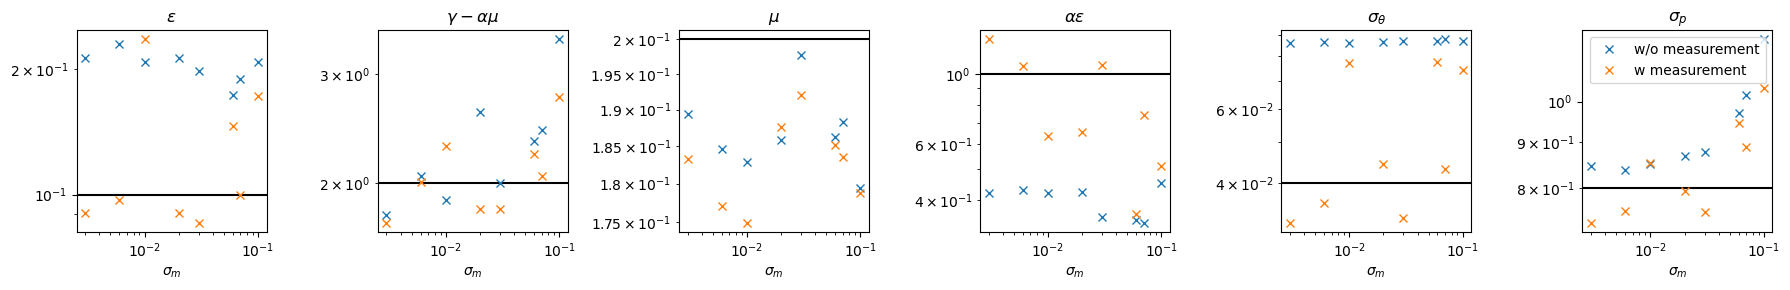

In [10]:
MAP1 = np.array(MAP1) 
MAP2 = np.array(MAP2) 

names = [r'$\epsilon$', r'$\gamma - \alpha \mu$', r'$\mu$', r'$\alpha \epsilon$', r'$\sigma_\theta$', r'$\sigma_p$']
fig, axes = plt.subplots(1, 6, figsize=(18, 3), sharex=True)
for i in range(6): 
    axes[i].axhline(params[i], c='black')
    axes[i].plot(msigmas, MAP1[:, i], 'x', label='w/o measurement')
    axes[i].plot(msigmas, MAP2[:, i], 'x', label='w measurement') 
    axes[i].set_title(names[i])
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    axes[i].set_xlabel(r'$\sigma_m$') 
plt.legend() 
plt.tight_layout()
plt.show() 

In [11]:
path = 'Data/N11_ThetaPola_DATA/'
files = [path + f for f in os.listdir(path) if f.endswith('mat')]
files.sort() # sort files so the polarization and theta are right next to each other in the list 

for element1, element2 in zip(files[::2], files[1::2]):
    print(f"{element1:} {element2:}")

theta_trajs = [] 
pol_trajs = []

for f in files: 
    if f.endswith('POLARIZATION.mat'):
        pol_trajs.append(loadmat(f)['POLA'])
    else: 
        theta_trajs.append(loadmat(f)['THETAd'])

Data/N11_ThetaPola_DATA/N11_1_R200_B30_04_05_POLARIZATION.mat Data/N11_ThetaPola_DATA/N11_1_R200_B30_04_05_ThetaTime.mat
Data/N11_ThetaPola_DATA/N11_1_R200_B50_04_05_POLARIZATION.mat Data/N11_ThetaPola_DATA/N11_1_R200_B50_04_05_ThetaTime.mat
Data/N11_ThetaPola_DATA/N11_1_R200_B50_25_04_POLARIZATION.mat Data/N11_ThetaPola_DATA/N11_1_R200_B50_25_04_ThetaTime.mat
Data/N11_ThetaPola_DATA/N11_1_R200_B50_26_04_POLARIZATION.mat Data/N11_ThetaPola_DATA/N11_1_R200_B50_26_04_ThetaTime.mat
Data/N11_ThetaPola_DATA/N11_2_R200_B50_26_04_POLARIZATION.mat Data/N11_ThetaPola_DATA/N11_2_R200_B50_26_04_ThetaTime.mat
Data/N11_ThetaPola_DATA/N11_3_R200_B50_25_04_POLARIZATION.mat Data/N11_ThetaPola_DATA/N11_3_R200_B50_25_04_ThetaTime.mat
Data/N11_ThetaPola_DATA/N11_4_R200_B100_25_04_POLARIZATION.mat Data/N11_ThetaPola_DATA/N11_4_R200_B100_25_04_ThetaTime.mat
Data/N11_ThetaPola_DATA/N11_4_R200_B30_25_04_POLARIZATION.mat Data/N11_ThetaPola_DATA/N11_4_R200_B30_25_04_ThetaTime.mat
Data/N11_ThetaPola_DATA/N11_4_

In [12]:
print(list(map(len, theta_trajs)))
print(list(map(len, pol_trajs)))

[print(theta[0, 0], p[0, 0]) for (theta, p) in zip(theta_trajs, pol_trajs) ];
is_finite = lambda p: np.isfinite(p[2])

del_list = [] 

for (i, (theta, p)) in enumerate(zip(theta_trajs, pol_trajs)): 
    if len(theta) != len(p) or np.any(np.isnan(p[:, 2])):
        del_list.append(i)
        
print(del_list)
for index in sorted(del_list, reverse=True):
    del theta_trajs[index]
    del pol_trajs[index]

[5000, 5000, 2450, 5000, 5000, 3000, 5000, 5000, 5000, 1300, 5000]
[5000, 5000, 2400, 5000, 5000, 3000, 5000, 5000, 5000, 1300, 5000]
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
[2]


In [13]:
print(list(map(np.shape, theta_trajs)))
print(list(map(np.shape, pol_trajs)))
dt = theta_trajs[0][0, 0]
print('dt = ', dt)

[(5000, 2), (5000, 2), (5000, 2), (5000, 2), (3000, 2), (5000, 2), (5000, 2), (5000, 2), (1300, 2), (5000, 2)]
[(5000, 4), (5000, 4), (5000, 4), (5000, 4), (3000, 4), (5000, 4), (5000, 4), (5000, 4), (1300, 4), (5000, 4)]
dt =  0.03333333333333333


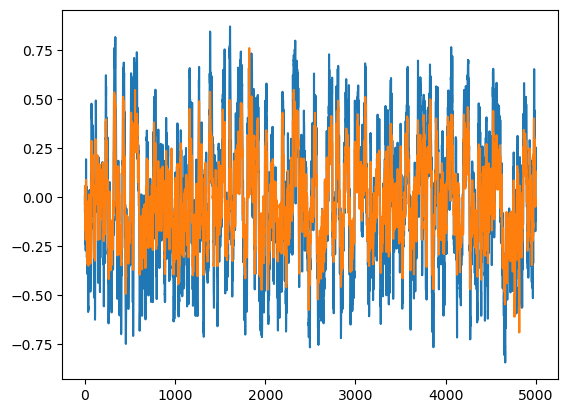

-0.01717776965751588
0.6583490700116748
-0.6938305831032138
-0.016051795881008666
0.7071067811865475


In [112]:
p = pol_trajs[0]
plt.plot(p[:, 2])
plt.plot(np.mean(p[:, 1:4], axis=-1))
plt.show() 

print(np.mean(p[:, 1:4]))
print(np.mean(p[:, 1]))
print(np.mean(p[:, 3]))
print(np.mean(p[:, 2]))

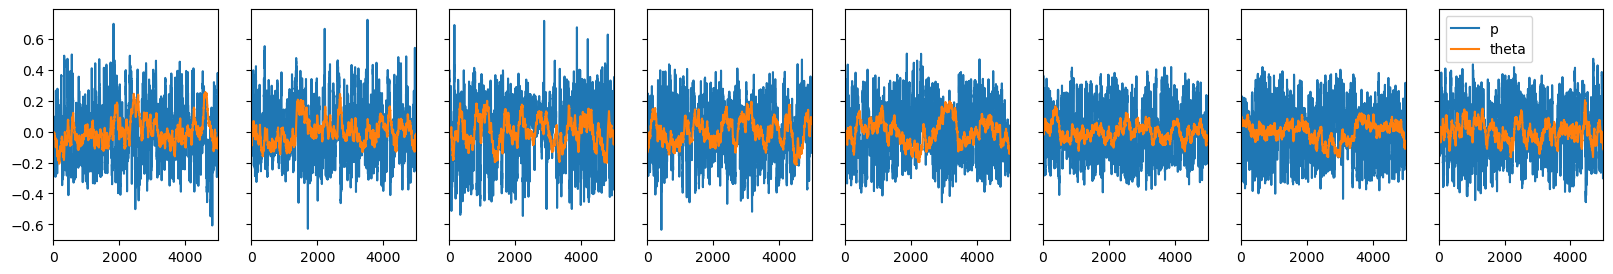

In [113]:
f1 = lambda x: (x[:, 1])/180*np.pi - np.mean(x[:, 1])/180*np.pi
f2 = lambda x: np.mean(np.sin(x[:, 1:]), axis=1) - np.mean(np.sin(x[:, 1:]))
f3 = lambda x: x[:, 2] - np.mean(x[:, 2])
data = [np.stack([f1(theta), f2(p)]) for (theta, p) in zip(theta_trajs, pol_trajs)]
show([d for d in data if len(d[0]) == 5000]) 

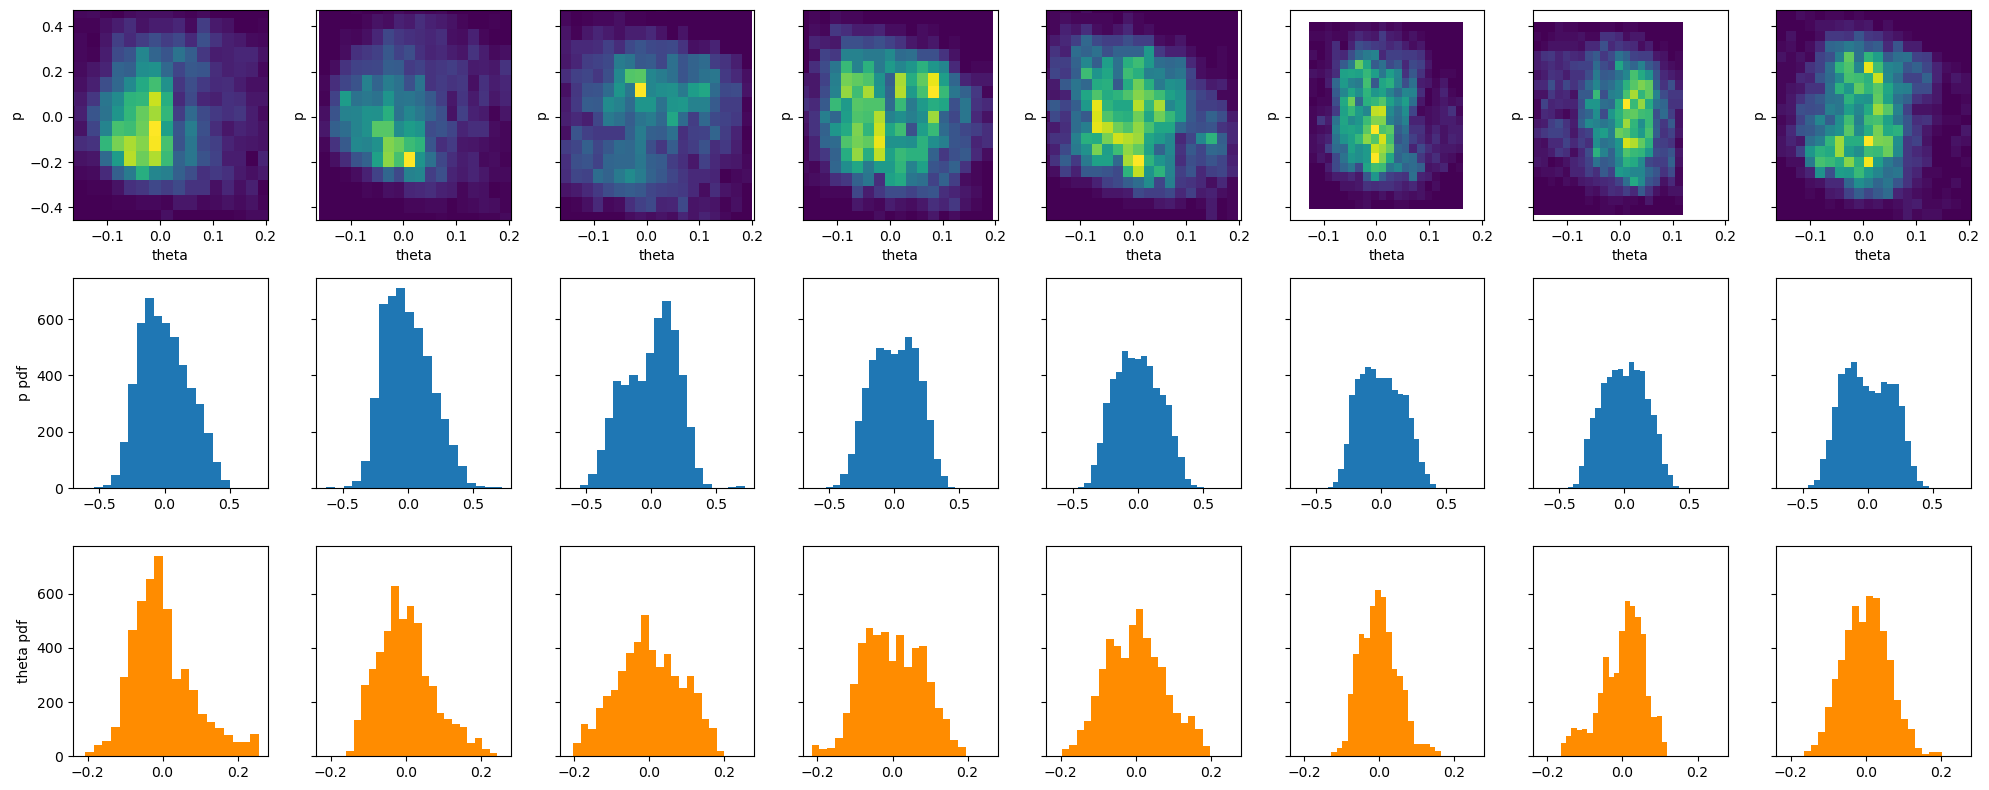

In [114]:
plot_dist([d for d in data if len(d[0]) == 5000])

In [75]:
guess = [3, 0.1, 0.1, 1, 1, 1, 0.01, 0.07]
bounds = [[1e-10, None], [1e-10, None], [1e-10, None], [1e-10, None], [1e-10, None], [1e-3, None], [1e-3, 0.02], [1e-3, 0.2]]
inf = measurement_inference(convert_params)
MAP, y = inf.inf(guess, data, dt, bounds=bounds)
print(MAP, y)

[0.0163 1.5355 0.3802 2.2849 0.0022 0.0205 0.0032 0.0196] -317991.53798178164


In [76]:
std_err, hess = inf.std_error(MAP, data, dt, delta=1e-4)
print(std_err)

[   nan    nan 0.0038 0.0987    nan 0.0363 0.        nan]


In [77]:
J, B = convert_params(MAP)
print(J)
print(B) 
print(np.linalg.eigvals(J))

[[-0.0163  0.3802]
 [-2.2849 -1.5355]]
[[0.     0.0007]
 [0.0007 0.0996]]
[-0.7759+0.5402j -0.7759-0.5402j]


In [78]:
n_frames = 5000
m = simple_model(MAP, convert_params)
n_repeats = 8
sims = m.evolve(n_frames*dt, 5e-3, n_frames, n_repeats)

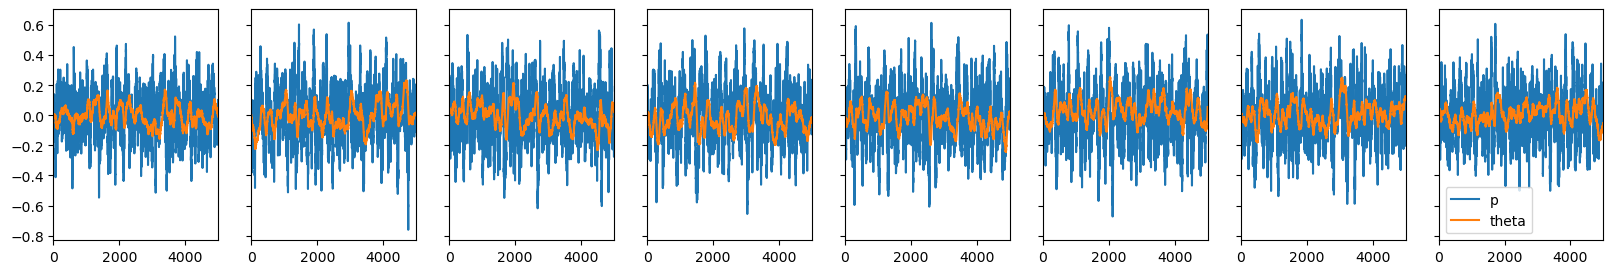

In [79]:
show(sims)

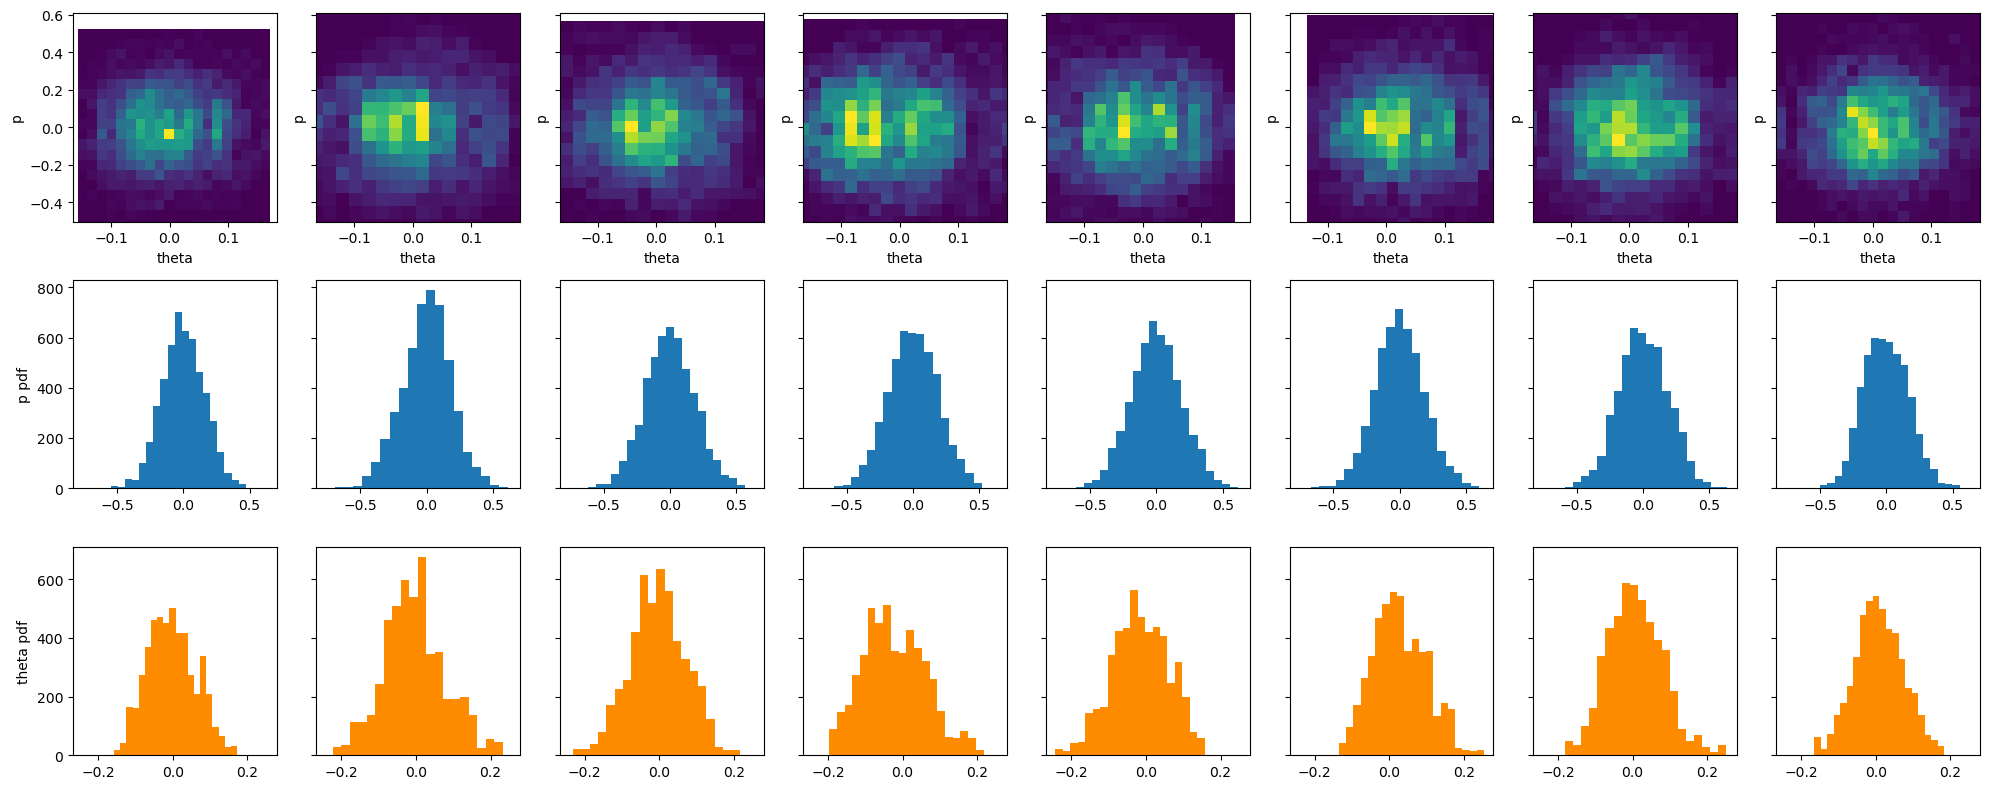

In [80]:
plot_dist(sims)

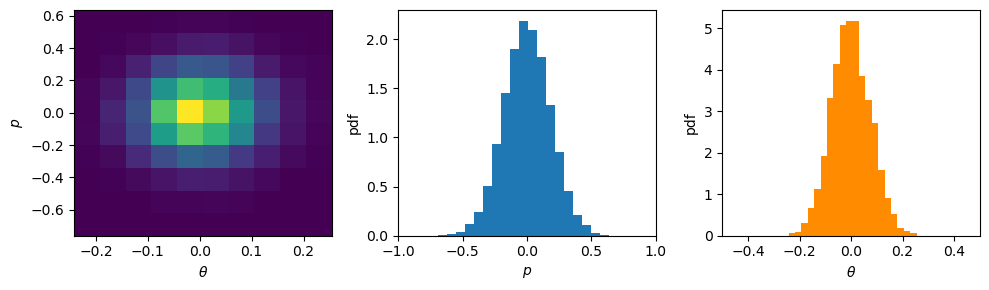

In [81]:
plot_overall_dist(sims)

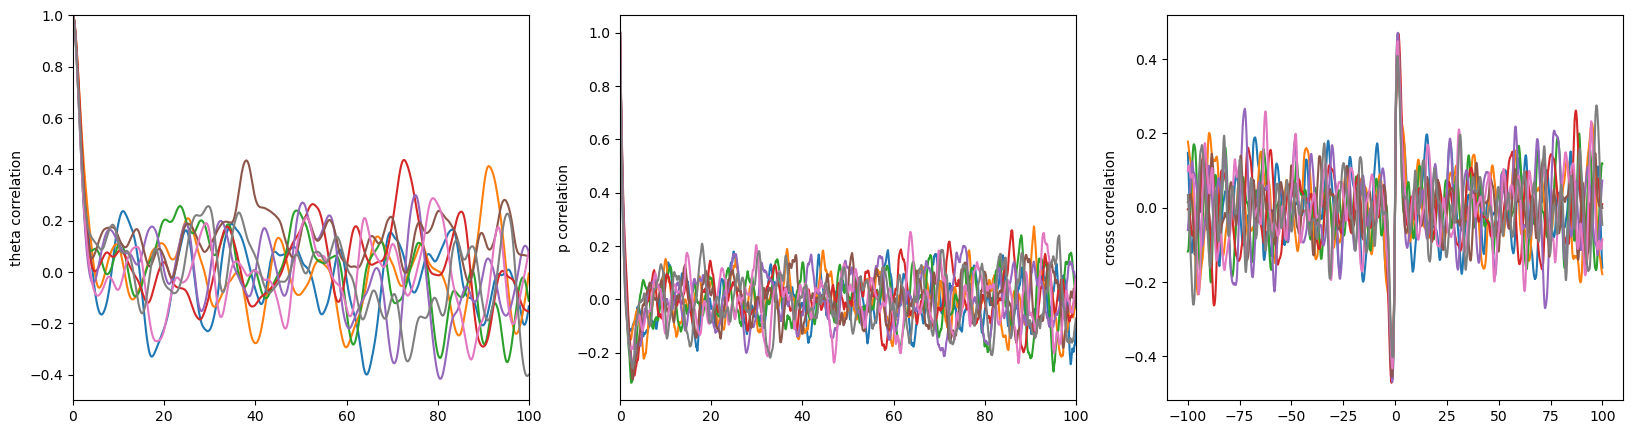

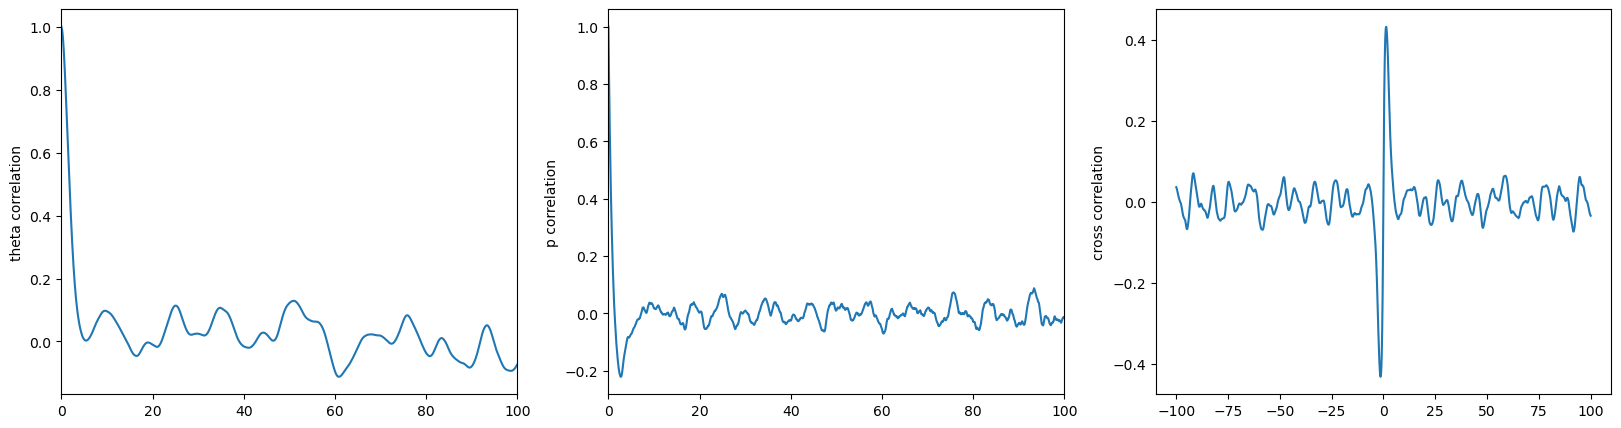

In [82]:
plot_corr(sims, 3000, dt); 

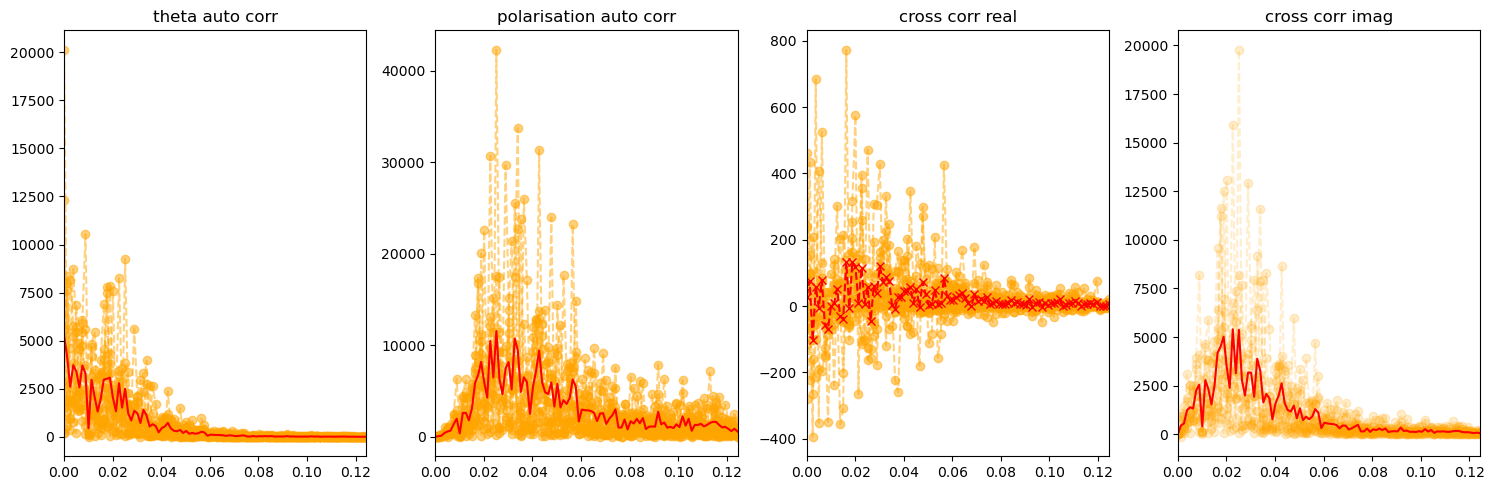

In [83]:
plot_corr_ft(np.array(sims), dt); 